In [13]:
from pathlib import Path
import dill
import pyro
from tqdm.notebook import tqdm

import numpy as np
import torch
from torch.distributions.gamma import Gamma
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from scripts.lga.utils import *



In [14]:
checkpoint_dir = Path.cwd().resolve() / "bayes-air-atrds-attempt-4/checkpoints/LGA/"

n_samples = 800

day_dir = checkpoint_dir / "2019-06-01" 

default_zero_scale = 1e-12
default_low_scale = .02
default_high_scale = .1

ppp_params = [
    (ptype, pscale, pguide)
    for ptype in ("failure", "nominal")
    for pscale in (default_low_scale, default_high_scale)
    for pguide in ("gaussian", "iafnormal")
] + [
    ("empty", default_zero_scale, pguide)
    for pguide in ("gaussian", "iafnormal")
]

samples = {}

fig = plt.figure()

for ptype, pscale, pguide in ppp_params:
    group = f'{ptype}_{pscale:.2f}_{pguide}'
    subdir = day_dir / group
    output_dict_path = subdir / "final/output_dict.pkl"

    with open(output_dict_path, 'rb') as f:
        output_dict = dill.load(f)

    pyro.clear_param_store()  # avoid leaking parameters across runs
    pyro.enable_validation(True)
    pyro.set_rng_seed(1)

    model = output_dict["model"]
    guide = output_dict["guide"]
    states = output_dict["states"]
    dt = output_dict["dt"]

    with pyro.plate("samples", n_samples, dim=-1):
        posterior_samples = guide(states, dt)

    # for key, samples in posterior_samples.items():
    #     posterior_samples[key] = samples.detach().cpu().numpy()

    samples[group] = posterior_samples["LGA_0_mean_service_time"].detach().cpu().numpy()

print(samples.keys())
print(samples)


dict_keys(['failure_0.02_gaussian', 'failure_0.02_iafnormal', 'failure_0.10_gaussian', 'failure_0.10_iafnormal', 'nominal_0.02_gaussian', 'nominal_0.02_iafnormal', 'nominal_0.10_gaussian', 'nominal_0.10_iafnormal', 'empty_0.00_gaussian', 'empty_0.00_iafnormal'])
{'failure_0.02_gaussian': array([0.01466653, 0.01585849, 0.01601833, 0.01454821, 0.01698354,
       0.01609355, 0.01548756, 0.01454875, 0.01592144, 0.01773017,
       0.01581397, 0.01671258, 0.01676445, 0.02044088, 0.01758863,
       0.01804156, 0.01594663, 0.01520561, 0.01848879, 0.01753375,
       0.01881318, 0.01761859, 0.01600339, 0.01869887, 0.01927814,
       0.0168472 , 0.01372068, 0.01478008, 0.01727793, 0.01607914,
       0.01577998, 0.01692678, 0.02082161, 0.01703431, 0.01745675,
       0.0158203 , 0.0175337 , 0.01724949, 0.0174478 , 0.01632085,
       0.01696393, 0.01770946, 0.01687963, 0.01711313, 0.02175526,
       0.01539686, 0.02021777, 0.01605879, 0.01557091, 0.01819022,
       0.01728737, 0.01638748, 0.01861157

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_3309842/3557069061.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


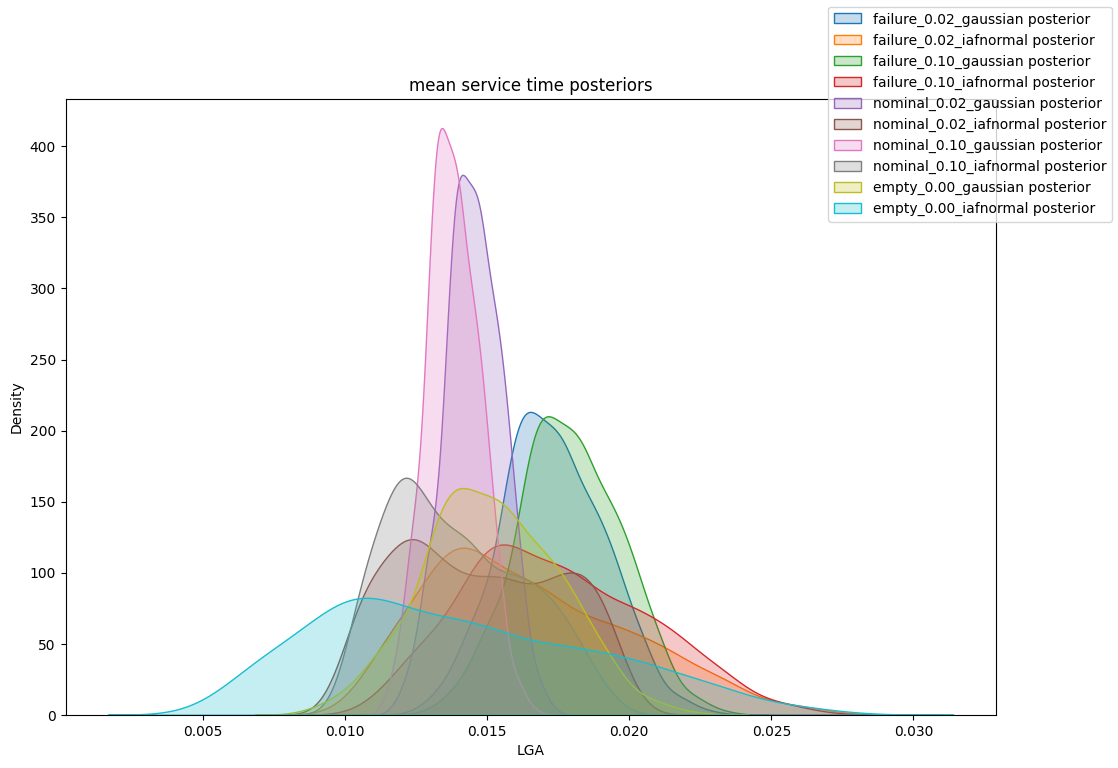

In [17]:
plotting_df = {}
groups = samples.keys()

# palette = {
#     'nominal posterior': "tab:blue", 'failure posterior': "tab:red",
#     'empty posterior': "tab:purple",
# } 

fig, ax = plt.subplots(figsize=(12, 8))

for group in groups:

    plotting_df[group] = pd.DataFrame(
        {
            "LGA": samples[group],
            "group": f'{group.split("_")[0]} posterior',
        },
    ) 

for group in groups:
    
    # sns.histplot(
    #     x="LGA",
    #     data=plotting_df[group],
    #     ax=ax,
    #     bins=64,
    #     stat="density",
    #     # shrink=0.8,
    #     hue="group",
    #     palette=palette,
    #     edgecolor='none',
    #     label=f"{group} posterior",
    #     # kde=True,
    # )

    sns.kdeplot(
        x="LGA",
        data=plotting_df[group],
        ax=ax,
        # hue="group",
        # palette=palette,
        label=f"{group} posterior",
        fill=True,
    )

ax.set_title("mean service time posteriors")
fig.legend()

fig.show()